In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import mlflow

from matplotlib.patches import Patch

from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error, PredictionErrorDisplay
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, MultiLabelBinarizer, OneHotEncoder, PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA


In [3]:
import sys

print(sys.executable)
print(sys.version)

C:\Users\diana\anaconda3\envs\mlflowenv\python.exe
3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:29:11) [MSC v.1935 64 bit (AMD64)]


# Weather Forecast
### Experiments

##### _Helper functions_

In [4]:
def create_lags(dataframe, column_list, n_lags):
    """
    Creates lags for the specified columns.
    Returns pandas DataFrame.
    """
    # TODO: check datetime order and missing days
    
    if type(column_list) == str:
        column_list = [column_list]

    lags = range(1, n_lags + 1)

    lags_dataframe = dataframe[column_list].shift(lags)

    assert dataframe.shape[0] == lags_dataframe.shape[0]

    return lags_dataframe

In [5]:
def plot_residuals(y_true, y_pred, feature):
    
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    
    PredictionErrorDisplay.from_predictions(
        y_true,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title("Actual vs. Predicted values")
    
    PredictionErrorDisplay.from_predictions(
        y_true,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    
    fig.suptitle(feature)
    plt.tight_layout()
    plt.show()

In [6]:
def plot_residuals_vs_time(temp_actual, temp_predicted, feature, dataframe):
    plt.figure(figsize=(12, 6))
    
    plt.scatter(dataframe.datetime[temp_actual.index], temp_predicted - temp_actual)

    for year in dataframe.datetime.dt.year.unique(): 
        plt.axvline(pd.Timestamp(year, 1, 1), c = "lightgrey", ls = "--")
    
    plt.title(f"{feature} - Residuals vs. Datetime")
    plt.show()

In [7]:
def plot_cv_indices(cv, X, ax, fig, n_splits, lw=10):
    """
    Create a sample plot for indices of a cross-validation object.
    Function copied (with few adjustments) from sklearn documentation at
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
    """

    cmap_cv = plt.cm.summer
    cmap_year = plt.cm.viridis
    cmap_precip = plt.cm.Blues
    cmap_temp = plt.cm.coolwarm
    cmap_cloudcover = plt.cm.Grays

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=X.temp, groups=X.dt_year)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data targets and years at the end    
    temp_scatter = ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=X.temp, marker="_", lw=lw, cmap=cmap_temp, label = "temp"
    )

    precip_scatter = ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=X.precip, marker="_", lw=lw, cmap=cmap_precip
    )

    cloudcover_scatter = ax.scatter(
        range(len(X)), [ii + 3.5] * len(X), c=X.cloudcover, marker="_", lw=lw, cmap=cmap_cloudcover
    )

    year_scatter = ax.scatter(
        range(len(X)), [ii + 4.5] * len(X), c=X.dt_year, marker="_", lw=lw, cmap=cmap_year
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["temp", "precip", "cloudcover", "year"]
    ax.set(
        yticks=np.arange(n_splits + 4) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index (days)",
        ylabel="CV iteration",
        ylim=[n_splits + 4.2, -0.2],
        xlim=[0, 1000],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)

    
    # Add colorbars
   
    plt.colorbar(temp_scatter, cax = fig.add_axes([0.95, 0.5, 0.3, 0.02]), orientation="horizontal").set_label(label = "Temperature [C$\degree$]", size=8)
    plt.colorbar(precip_scatter, cax = fig.add_axes([0.95, 0.35, 0.3, 0.02]), orientation="horizontal").set_label(label="Precipitation [mm]", size=8)
    plt.colorbar(cloudcover_scatter, cax = fig.add_axes([0.95, 0.2, 0.3, 0.02]), orientation="horizontal").set_label(label="Cloud Cover [%]", size=8)
    
    ax.legend(
        [Patch(color=cmap_cv(0.02)), Patch(color=cmap_cv(0.8)),
         Patch(color=cmap_year(0.02)), Patch(color=cmap_year(0.5)),Patch(color=cmap_year(0.98))],
        ["Training set", "Validation set", "2021", "2022", "2023"],
        loc=(1.02, 0.7),
    )
    
    return ax

In [8]:
def plot_score_cv(cv_results, target = "temp", score_metrics = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error"), skip_folds = 0):
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6), constrained_layout = True)
    fig.suptitle(f"Cross Validation Scores, Target: {target}")

    
    n_folds = len(cv_results["test_r2"])
    fold_indeces = np.arange(n_folds)


    for metric, ax in zip(score_metrics, axs.flat):
        
        ax.plot(fold_indeces[skip_folds:], cv_results[f"train_{metric}"][skip_folds:], label = "train")
        ax.plot(fold_indeces[skip_folds:], cv_results[f"test_{metric}"][skip_folds:], label = "validation")

        ax.set_xlabel("Fold index")
        ax.set_xticks(fold_indeces)
        ax.set_ylabel(metric)
        ax.legend()
    
    plt.show()

In [9]:
def plot_cv_predictions(cv_results, input_dataframe, target_column, n_fold = -1):
    plt.figure(figsize=(13, 4))

    
    estimator = cv_results["estimator"][n_fold]
    
    plt.plot(input_dataframe.datetime, input_dataframe[target_column], c = "lime", lw = 1, label = "actual values") # y_true
    
    indices_train = cv_results["indices"]["train"][n_fold]
    predictions_train = estimator.predict(input_dataframe.loc[indices_train])
    plt.plot(input_dataframe.datetime.loc[indices_train], predictions_train, lw = 1, label = "predictions train set")

    indices_test = cv_results["indices"]["test"][n_fold]
    predictions_test = estimator.predict(input_dataframe.loc[indices_test])
    plt.plot(input_dataframe.datetime.loc[indices_test], predictions_test, lw = 1, label = "predictions validation set")

    plt.title(f"Predictions of Model trained on Fold {n_fold}")
    plt.ylabel(target_column)
    plt.legend()

    plt.show()


## 3. Experiments

In [10]:
# experiment = mlflow.create_experiment(name = "simple_naive")

In [11]:
# run = mlflow.start_run()

In [12]:
file_path = "data/Sofia 2021-01-01 to 2023-09-26.csv"

In [13]:
# mlflow.log_artifact(file_path)

In [14]:
weather_data_raw = pd.read_csv(file_path)
weather_data_raw.head(2)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Sofia,2021-01-01,11.1,-0.9,3.9,11.1,-1.4,3.1,0.1,78.2,...,NaN,NaN,NaN,2021-01-01T07:57:10,2021-01-01T17:03:43,0.58,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,15614099999
1,Sofia,2021-01-02,9.1,-3.9,1.6,7.9,-5.1,0.7,-2.0,78.8,...,NaN,NaN,NaN,2021-01-02T07:57:14,2021-01-02T17:04:36,0.62,Clear,Clear conditions throughout the day.,clear-day,15614099999


In [15]:
weather_data_raw.shape

(999, 33)

In [16]:
weather_data_raw.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [17]:
weather_data = weather_data_raw.copy()
weather_data.datetime = pd.to_datetime(weather_data.datetime)
weather_data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Sofia,2021-01-01,11.1,-0.9,3.9,11.1,-1.4,3.1,0.1,78.2,...,NaN,NaN,NaN,2021-01-01T07:57:10,2021-01-01T17:03:43,0.58,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,15614099999
1,Sofia,2021-01-02,9.1,-3.9,1.6,7.9,-5.1,0.7,-2.0,78.8,...,NaN,NaN,NaN,2021-01-02T07:57:14,2021-01-02T17:04:36,0.62,Clear,Clear conditions throughout the day.,clear-day,15614099999
2,Sofia,2021-01-03,10.1,2.1,5.8,10.1,-1.1,4.4,3.5,86.0,...,NaN,NaN,NaN,2021-01-03T07:57:15,2021-01-03T17:05:31,0.65,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,15614099999
3,Sofia,2021-01-04,9.1,5.1,6.8,7.6,3.3,5.6,5.4,90.8,...,NaN,NaN,NaN,2021-01-04T07:57:13,2021-01-04T17:06:28,0.69,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,15614099999
4,Sofia,2021-01-05,11.1,2.1,6.8,11.1,0.6,5.7,2.3,75.2,...,NaN,NaN,NaN,2021-01-05T07:57:09,2021-01-05T17:07:26,0.72,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,15614099999


### 3.1. Naive Forcating

Naive forecasting is one of the simplest time series forecasting techniques. The basic idea behind it is to assume that the future values of a time series will be the same as the last observed value. In other words, it assumes that there will be no change from the current state. This method exploits recency bias - assuming the most recent values are best predictors of the current value. Naive forecasting is almost always oversimplification of the problem, but is good for imputation in models with many exogenous features, or as base for comparing with more complex models.

Naive model would be:

$$ \tilde{y}_{(t)} = y_{(t - 1)} \textnormal {, where} $$
$$ \tilde{y}_{(t)} \textnormal { is the predicted value at time t } $$
$$ y_{(t - 1)} \textnormal { is the observed value at time t -1 (previous day)} $$

We make 3 separate naive models for average temperature, precipitation and cloud cover. `lag_1` are the previous values of the corresponding variable. Since there are no missing values in these features, as well as in the `datetime` column (saw that in the EDA), we obtain previous day value by simply shifting original values by one row:

In [18]:
weather_data_naive = weather_data[["datetime", "temp", "precip", "cloudcover"]]
weather_data_naive.isna().sum()

datetime      0
temp          0
precip        2
cloudcover    1
dtype: int64

In [19]:
weather_data_naive = weather_data_naive.fillna(0)

In [20]:
lags = create_lags(weather_data_naive, ["temp", "precip", "cloudcover"], 1)

In [21]:
weather_data_naive = pd.concat([weather_data_naive, lags], axis = 1)
weather_data_naive

,datetime,temp,precip,cloudcover,temp_1,precip_1,cloudcover_1
0,2021-01-01,3.9,1.8,32.4,NaN,NaN,NaN
1,2021-01-02,1.6,0.0,8.3,3.9,1.8,32.4
2,2021-01-03,5.8,0.3,75.2,1.6,0.0,8.3
3,2021-01-04,6.8,4.0,96.3,5.8,0.3,75.2
4,2021-01-05,6.8,3.0,78.1,6.8,4.0,96.3
...,...,...,...,...,...,...,...
994,2023-09-22,21.9,0.5,42.8,19.8,0.0,46.8
995,2023-09-23,23.1,0.0,21.4,21.9,0.5,42.8
996,2023-09-24,21.5,5.0,38.8,23.1,0.0,21.4
997,2023-09-25,20.2,0.0,55.2,21.5,5.0,38.8


Since there is no learning involved - our naive model is just simple mapping, we skip splitting into train and validation set and score on the whole dataset. Test set is however not included here, this is discussed later in this work. _Actual_ values $y$ are the values from the original columns, and _predicted_ $\tilde{y}$ are the lags. We drop the first row, because of the NaNs created from the shift and score. First we make sure there is only one NaN in each of the lag columns and drop them: 



In [22]:
weather_data_naive.isna().sum()

datetime        0
temp            0
precip          0
cloudcover      0
temp_1          1
precip_1        1
cloudcover_1    1
dtype: int64

In [23]:
weather_data_naive = weather_data_naive.dropna()
weather_data_naive

,datetime,temp,precip,cloudcover,temp_1,precip_1,cloudcover_1
1,2021-01-02,1.6,0.0,8.3,3.9,1.8,32.4
2,2021-01-03,5.8,0.3,75.2,1.6,0.0,8.3
3,2021-01-04,6.8,4.0,96.3,5.8,0.3,75.2
4,2021-01-05,6.8,3.0,78.1,6.8,4.0,96.3
5,2021-01-06,5.1,0.0,60.5,6.8,3.0,78.1
...,...,...,...,...,...,...,...
994,2023-09-22,21.9,0.5,42.8,19.8,0.0,46.8
995,2023-09-23,23.1,0.0,21.4,21.9,0.5,42.8
996,2023-09-24,21.5,5.0,38.8,23.1,0.0,21.4
997,2023-09-25,20.2,0.0,55.2,21.5,5.0,38.8


In [24]:
temp_actual = weather_data_naive.temp
temp_predicted = weather_data_naive.temp_1

In [25]:
r2_score(temp_actual, temp_predicted)

0.930667017395547

In [26]:
mean_squared_error(temp_actual, temp_predicted)

4.897765531062125

In [27]:
mean_absolute_error(temp_actual, temp_predicted)

1.607114228456914

The results seem unreasonably good. Since we have not scaled our data, the unit of Mean absolute error is the same as the original unit of the variable. MAE under 2 degrees C sounds great - why would we even need a more complex model? Wait this is __mean__, let's see the maximum error:

In [28]:
max_error(temp_actual, temp_predicted)

14.3

Error of 14 degrees is not acceptable. So initial scoring was not enough to evaluate the model. Let's examine residual plot:

In [29]:
# temp_actual

In [30]:
# def plot_residuals(y, y_pred):
#     plt.scatter(y, y_pred - y)

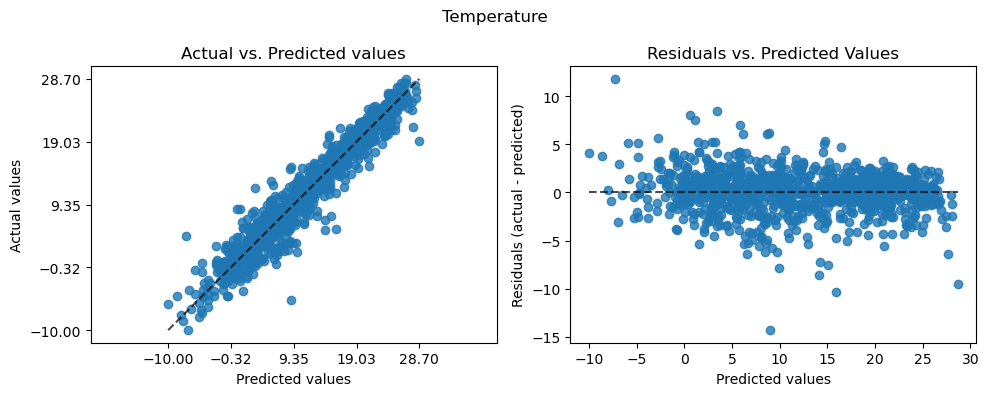

In [31]:
plot_residuals(temp_actual, temp_predicted, "Temperature")

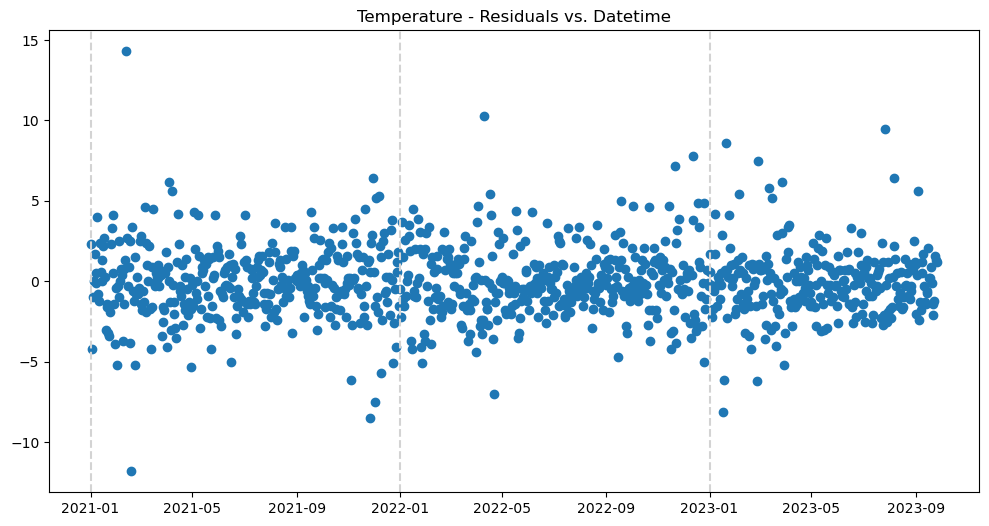

In [32]:
plot_residuals_vs_time(temp_actual, temp_predicted, "Temperature", weather_data_naive)

Let's see the scoring of precipitation and cloudcover:

In [33]:
precip_actual = weather_data_naive.precip
precip_predicted = weather_data_naive.precip_1

In [34]:
r2_score(precip_actual, precip_predicted)

-0.5453311677961608

In [35]:
mean_squared_error(precip_actual, precip_predicted)

36.766593186372745

In [36]:
mean_absolute_error(precip_actual, precip_predicted)

2.4585170340681364

In [37]:
max_error(precip_actual, precip_predicted)

58.0

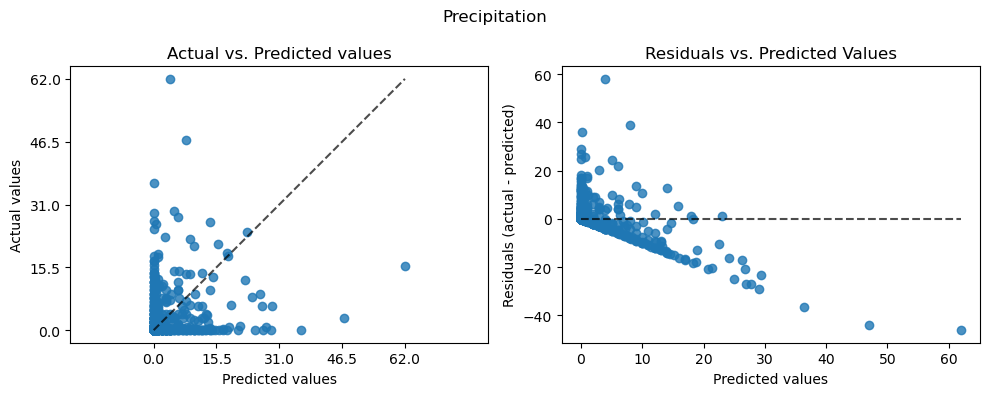

In [38]:
plot_residuals(precip_actual, precip_predicted, "Precipitation")

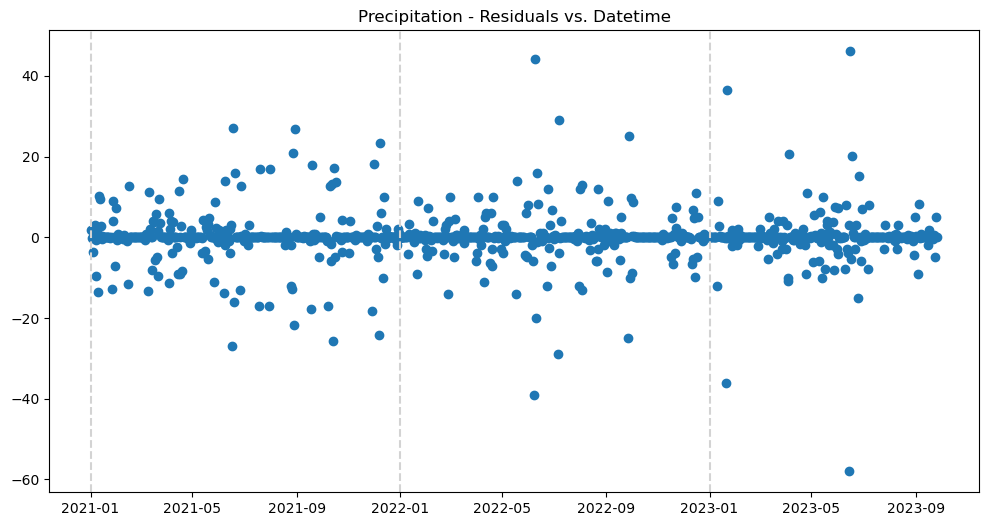

In [39]:
plot_residuals_vs_time(precip_actual, precip_predicted, "Precipitation", weather_data_naive)

In [40]:
cloudcover_actual = weather_data_naive.cloudcover
cloudcover_predicted = weather_data_naive.cloudcover_1

In [41]:
r2_score(cloudcover_actual, cloudcover_predicted)

0.29711056246819445

In [42]:
mean_absolute_error(cloudcover_actual, cloudcover_predicted)

17.053507014028057

In [43]:
max_error(cloudcover_actual, cloudcover_predicted)

79.2

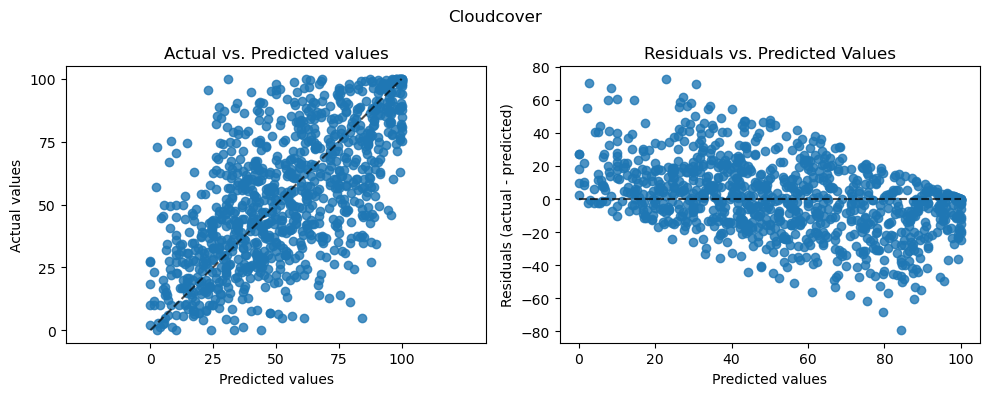

In [44]:
plot_residuals(cloudcover_actual, cloudcover_predicted, "Cloudcover")

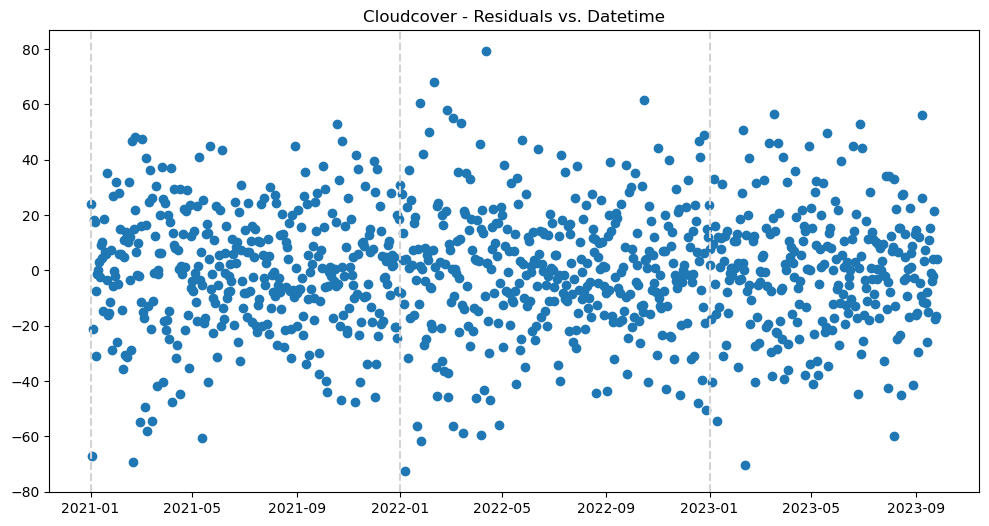

In [45]:
plot_residuals_vs_time(cloudcover_actual, cloudcover_predicted, "Cloudcover", weather_data_naive)

Terrible results for precipitation and cloud cover, as expected. This is forecasting for only 1 day ahead. As most of our values are daily average, we can predict a day's values after the previous has ended, which basically means today we predict for today - not useful at all. But the bad results make trying to forecast 2 or more days ahead obsolete. We need to make more complex model.

### 3.1. Autoregression

Autoregression is a time series forecasting model that uses observations from previous time steps as input to predict the value at one or several time steps ahead. In other words, it predicts the future values of a time series based on its own past values. In sklearn the way to add information from past observations (other rows) is to directly add them as features to the current observation, each new feature being the value at $n$ time steps back.  


![autoregression](https://cienciadedatos.net/images/transform_timeseries.gif)

+ _Time series transformation into a matrix of 5 lags and a vector with the value of the series that follows each row of the matrix._
[[source]](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)

This approach allows us to also add exogenous variables - ones that are not time-related. In a weather forecasting model exogenous variables would be mostly location-related - latitude, altitude, terrain and proximity to large bodies of water. Since we will be forecasting for a single location all those features are ignored in our work.

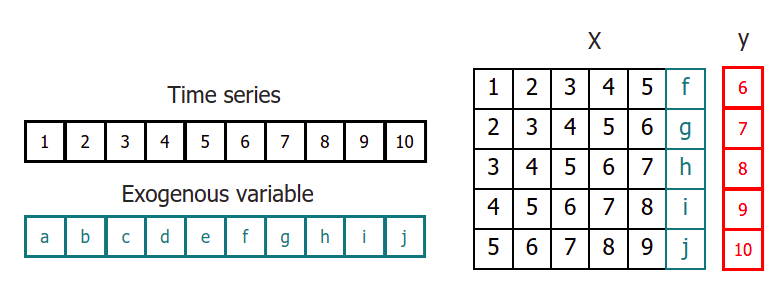

+ _Time series transformation including an exogenous variable._
[[source]](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)

All of our variables are endogenous - they are both function of time and influence each others' future values. This means our task is actually __Vector Autoregression__ - a fancy way of saying that each of the original features is also a target. Usually temperature, humidity, precipitation, air pressure, wind speed, and wind direction are the main components of describing and forecasting weather conditions, but for simplicity our base features and targets will be temperature, precipitation and cloudcover, although we will use other features in the more complex models. Lags chosen are 1 to 10, meaning we will have past 10 days as input and predict the current day - that is __single step forecasting__. This may not be very useful in real life, but is enough to evaluate and compare models, __recursive multi-step forecasting__ will be tried only with our final model. That means, that we should keep in mind that all metrics will be somewhat better than the final performance.

For autoregressive models we have chosen Linear Regression for estimator in order to easily compare progressively more complex models. Assumption is they would severely underfit the data and not need regularisation anyway.



In [46]:
n_lags = 10
base_features = ["temp", "precip", "cloudcover"]
features_with_lag = [
    "tempmax", "tempmin", "temp", 
    "dew", "humidity", 
    "precip", "precipprob", "precipcover", "preciptype", 
    "snow", "snowdepth", 
    "windgust", "windspeed", "winddir", 
    "sealevelpressure", 
    "cloudcover", "visibility", 
    "conditions", "description", "icon"
]

In [47]:
# little cheat, impute with constant before lags
weather_data.preciptype = weather_data.preciptype.fillna("no_precip")

In [48]:
lags_df = create_lags(weather_data, features_with_lag, n_lags)
# lags_df

In [49]:
weather_data_with_lags_raw = pd.concat([weather_data, lags_df], axis = 1)
weather_data_with_lags_raw.head(3)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,snowdepth_10,windgust_10,windspeed_10,winddir_10,sealevelpressure_10,cloudcover_10,visibility_10,conditions_10,description_10,icon_10
0,Sofia,2021-01-01,11.1,-0.9,3.9,11.1,-1.4,3.1,0.1,78.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
1,Sofia,2021-01-02,9.1,-3.9,1.6,7.9,-5.1,0.7,-2.0,78.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
2,Sofia,2021-01-03,10.1,2.1,5.8,10.1,-1.1,4.4,3.5,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None


In [50]:
weather_data_with_lags_raw.shape

(999, 233)

We drop first 10 rows - the ones with missing values in the lags:

In [51]:
weather_data_with_lags = weather_data_with_lags_raw.drop(range(n_lags))

In [52]:
weather_data_with_lags = weather_data_with_lags.reset_index()

In [53]:
weather_data_with_lags["dt_year"] = weather_data_with_lags.datetime.dt.year # for visualisation of cv split

In [54]:
weather_data_with_lags.shape

(989, 235)

In [55]:
weather_data_with_lags.head(3)

,index,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,...,windgust_10,windspeed_10,winddir_10,sealevelpressure_10,cloudcover_10,visibility_10,conditions_10,description_10,icon_10,dt_year
0,10,Sofia,2021-01-11,5.1,1.1,2.7,3.4,-2.1,0.3,1.8,...,NaN,16.6,232.9,1014.9,32.4,12.3,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,2021
1,11,Sofia,2021-01-12,1.1,-0.9,0.3,1.1,-6.8,-2.0,-0.4,...,NaN,16.6,111.8,1021.1,8.3,12.4,Clear,Clear conditions throughout the day.,clear-day,2021
2,12,Sofia,2021-01-13,1.2,-1.3,-0.3,-0.9,-7.0,-4.7,-3.0,...,NaN,20.5,120.0,1018.3,75.2,11.3,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,2021


### 3.2. Times Series Split

In order to evaluate our autoregressive models we need proper train test split (or train validation actually, since our test data is in separate dataset). Default train test split with shuffling is not suitable for time series, since it would lead to data leakage - future target values from the validation and test sets will be present in the training set as lags.

First approach to this problem is __TimeSeriesSplit__ - a variation of KFold that  splits time series data samples at fixed time intervals. Number of splits and test size were chosen considering that out dataset is quite small - so we need as many folds as possible, but a fold with less than 360 train samples (days) is practically useless, because it can not reflect the seasonality in our data. No gap between train nad validation is left, because we predict only one day ahead (and we know final results will be somewhat worse). 

We split our data and visualize the folds:

In [56]:
n_splits = 10
gap = 0
time_series_cv = TimeSeriesSplit(n_splits = n_splits, gap = gap)

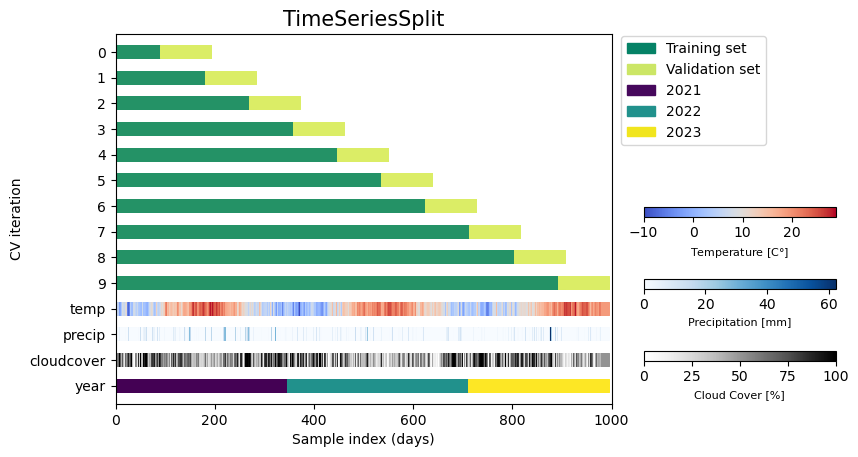

In [57]:
fig = plt.figure()
ax = plt.subplot(111)

plot_cv_indices(time_series_cv, weather_data_with_lags, ax, fig, n_splits)

plt.show()

#### 3.3. Linear Model Temperature

First we make simple autoregressive model with pipeline for Temperature:

In [58]:
temp_column_selector = make_column_selector(pattern = "temp_") # select "temp_n", excluding "temp"

In [59]:
temp_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy = "mean")),
        ("scale", MinMaxScaler())
    ]
)

In [60]:
feature_preprocessor = ColumnTransformer(
    transformers=[
        ("temp", temp_transformer, temp_column_selector)
    ],
    verbose_feature_names_out = False,
    # sparse_threshold=0.0
)

In [61]:
weather_features = feature_preprocessor.fit_transform(weather_data_with_lags)

In [62]:
feature_preprocessor.get_feature_names_out()

array(['temp_1', 'temp_2', 'temp_3', 'temp_4', 'temp_5', 'temp_6',
       'temp_7', 'temp_8', 'temp_9', 'temp_10'], dtype=object)

In [63]:
weather_features.shape

(989, 10)

In [64]:
temp_target = weather_data_with_lags.temp

In [65]:
pipe_autoregression = Pipeline(
    steps=[
        ("preprocess", feature_preprocessor),
        ("model", LinearRegression())
    ]
)

For loss function we have kept the default r2 for Linear Regression. For evaluation along with r2, we have chosen MSE because of higher penalty for larger errors, MAE and max error because they are very intuitively interpreted. In sklearn's cross validation they are readily available as scorers, but except r2 as a negative of the original metric:

+ _"All scorer objects follow the convention that higher return values are better than lower return values. Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric."_

In [66]:
scoring_metrics = "r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error"

In [67]:
cv_results_temperature = cross_validate(
    pipe_autoregression, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.temp, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

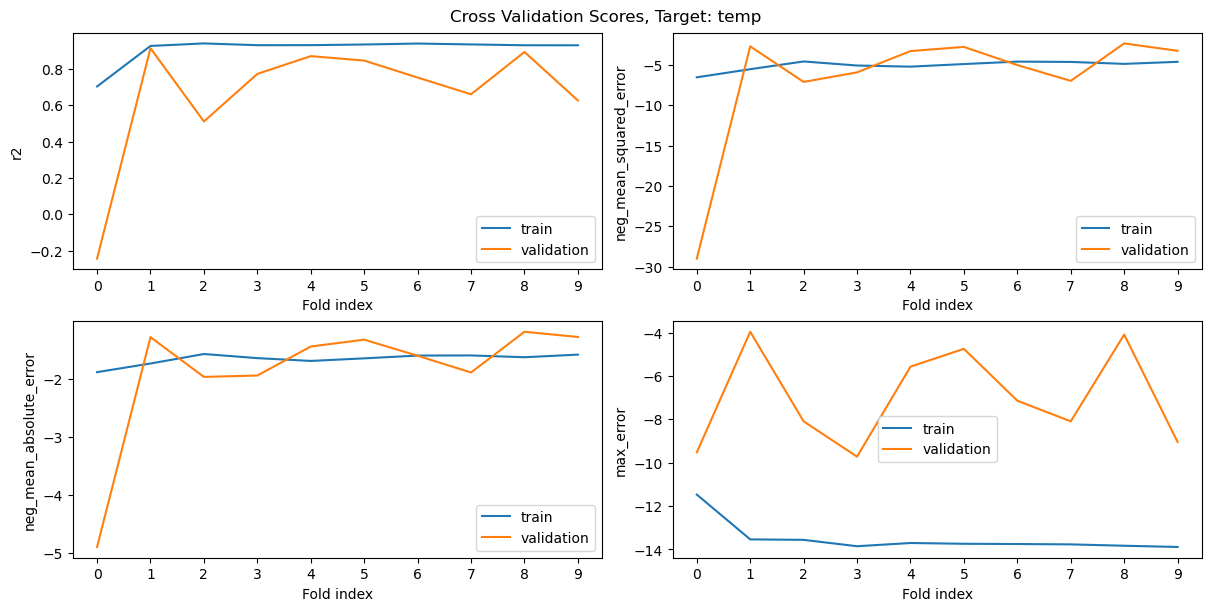

In [68]:
plot_score_cv(cv_results_temperature)

From the plots of cross-validation scores we can see that the first fold is useless, model has low scores even on the training set.

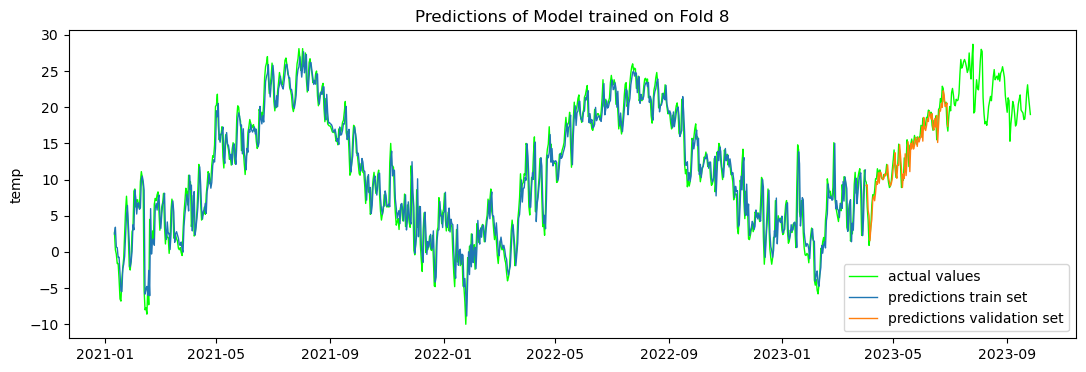

In [69]:
plot_cv_predictions(cv_results_temperature, weather_data_with_lags, "temp", n_fold = 8)

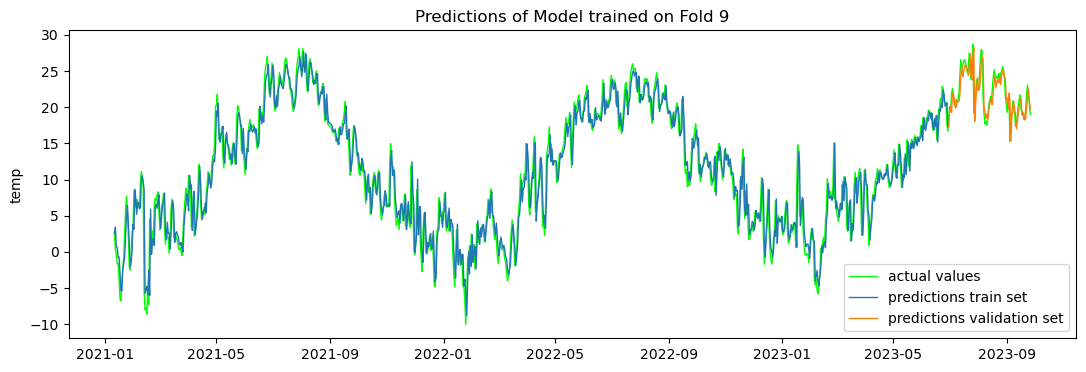

In [70]:
plot_cv_predictions(cv_results_temperature, weather_data_with_lags, "temp", n_fold = 9)

Overall predictions are not too bad, but the model clearly underestimates peak values. That, along with the cv scores is indication of high bias.

Let's explore the coefficients of each estimator:

In [71]:
feature_names = pipe_autoregression[-2].get_feature_names_out()

In [72]:
pd.DataFrame([estimator["model"].coef_ for estimator in cv_results_temperature["estimator"]], columns = feature_names).rename_axis("Fold_Index")

,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6,temp_7,temp_8,temp_9,temp_10
Fold_Index,,,,,,,,,,
0,20.478936,-3.807335,0.544722,-4.493322,5.887582,-7.845329,6.435569,-3.208044,3.392668,-3.647860
1,38.644530,-6.014341,-1.523119,-2.769755,8.852627,-9.672838,7.915806,-3.639064,4.376643,-1.255764
2,40.109784,-8.371111,1.923804,-4.430105,7.533786,-7.734670,8.818335,-6.358778,5.335461,-1.021360
3,38.233823,-8.009776,1.004961,0.125974,3.098596,-4.346799,6.530963,-2.672281,1.684801,0.217797
4,39.143693,-8.197227,2.534011,-2.019205,3.667419,-2.523765,5.074643,-1.845846,2.489502,-1.171829
5,39.214276,-8.244548,2.474718,-2.138295,3.389075,-2.161760,5.399130,-2.161451,2.706500,-1.192627
6,39.564377,-8.342936,2.331403,-2.237550,3.148686,-1.717520,4.741696,-2.194029,2.582405,-0.596912
7,39.083562,-8.394686,2.589445,-2.603153,3.391680,-0.714419,3.662992,-1.132329,0.650858,0.768354
8,39.329545,-9.292093,2.151740,-0.186465,2.053207,-0.367009,2.819206,-1.580097,1.587215,0.707372


As expected first lag is by far the most important predictor. For now we keep them all and assume adding more lags would not be beneficial.

### 3.3. Linear Model Base Features

In [73]:
n_splits = 10
gap = 0
time_series_cv = TimeSeriesSplit(n_splits = n_splits, gap = gap)

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

plot_cv_indices(time_series_cv, weather_data_with_lags, ax, fig, n_splits)

plt.show()

In [ ]:
temp_column_selector = make_column_selector(pattern = "temp_*") # select "temp_lag_n", excluding "temp"

In [ ]:
temp_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy = "mean")),
        ("scale", MinMaxScaler())
    ]
)

In [ ]:
feature_preprocessor = ColumnTransformer(
    transformers=[
        ("temp", temp_transformer, temp_column_selector)
    ],
    verbose_feature_names_out = False,
    # sparse_threshold=0.0
)

In [ ]:
weather_features = feature_preprocessor.fit_transform(weather_data_with_lags)

In [ ]:
feature_preprocessor.get_feature_names_out()

In [ ]:
weather_features

In [ ]:
temp_target = weather_data_with_lags.temp

In [ ]:
pipe_autoregression = Pipeline(
    steps=[
        ("preprocess", feature_preprocessor),
        ("model", LinearRegression())
    ]
)

In [ ]:
cv_results_temperature = cross_validate(
    pipe_linear_regression, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.temp, # y
    scoring = ("r2", "neg_mean_squared_error"), 
    cv = time_series_cv, 
    return_train_score = True, 
    # return_indices = True,
    return_estimator = True
)

In [ ]:
cv_results_temperature["train_r2"]

In [ ]:
cv_results_temperature["test_r2"] # validation score

In [ ]:
cv_results_temperature["train_neg_mean_squared_error"]

In [ ]:
cv_results_temperature["test_neg_mean_squared_error"]

In [ ]:
for estimator in cv_results_temperature["estimator"]: # TODO: ugly
    print(estimator["model"].coef_)

skip autoregression for precip and cloudcover


In order to improve our model we add the other base features and evaluate all 3 targets. As sklearn's approach to multi output regression is making independant models for each target anyway, we make three separate models for easier evaluation and visualisation:

In [74]:
precip_column_selector = make_column_selector(pattern = "precip_") # excluding "precip"

In [75]:
cloudcover_column_selector = make_column_selector(pattern = "cloudcover_") # excluding "cloudcover"

In [76]:
log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

In [77]:
precip_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy = "constant", fill_value = 0)),
        ("log_transform", log_transformer),
        ("scale", MinMaxScaler())
    ]
)

In [78]:
cloudcover_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy = "constant", fill_value = 0)),
        ("scale", MinMaxScaler())
    ]
)

In [79]:
feature_preprocessor = ColumnTransformer(
    transformers=[
        ("temp", temp_transformer, temp_column_selector),
        ("precip", precip_transformer, precip_column_selector),
        ("cloudcover", cloudcover_transformer, cloudcover_column_selector)
    ],
    verbose_feature_names_out = False,
    # sparse_threshold=0.0
)

In [80]:
pipe_linear_regression_base_features = Pipeline(
    steps=[
        ("preprocess", feature_preprocessor),
        ("model", LinearRegression())
    ]
)

In [81]:
# just checking, actual fit inside the cv
pipe_linear_regression_base_features.fit(weather_data_with_lags, weather_data_with_lags.temp)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('temp',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017D5100E450>),
                                                 ('precip',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(fe...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017D51164E10>),
                                                 ('cloudcover',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017D51167D50>)],
                                   verbose_feature_names_out=False)),
                ('model', LinearRegression())])

In [82]:
pipe_linear_regression_base_features[:-1].get_feature_names_out()

array(['temp_1', 'temp_2', 'temp_3', 'temp_4', 'temp_5', 'temp_6',
       'temp_7', 'temp_8', 'temp_9', 'temp_10', 'precip_1', 'precip_2',
       'precip_3', 'precip_4', 'precip_5', 'precip_6', 'precip_7',
       'precip_8', 'precip_9', 'precip_10', 'cloudcover_1',
       'cloudcover_2', 'cloudcover_3', 'cloudcover_4', 'cloudcover_5',
       'cloudcover_6', 'cloudcover_7', 'cloudcover_8', 'cloudcover_9',
       'cloudcover_10'], dtype=object)

In [83]:
cv_results_temperature = cross_validate(
    pipe_linear_regression_base_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.temp, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

In [84]:
# cv_results_temperature

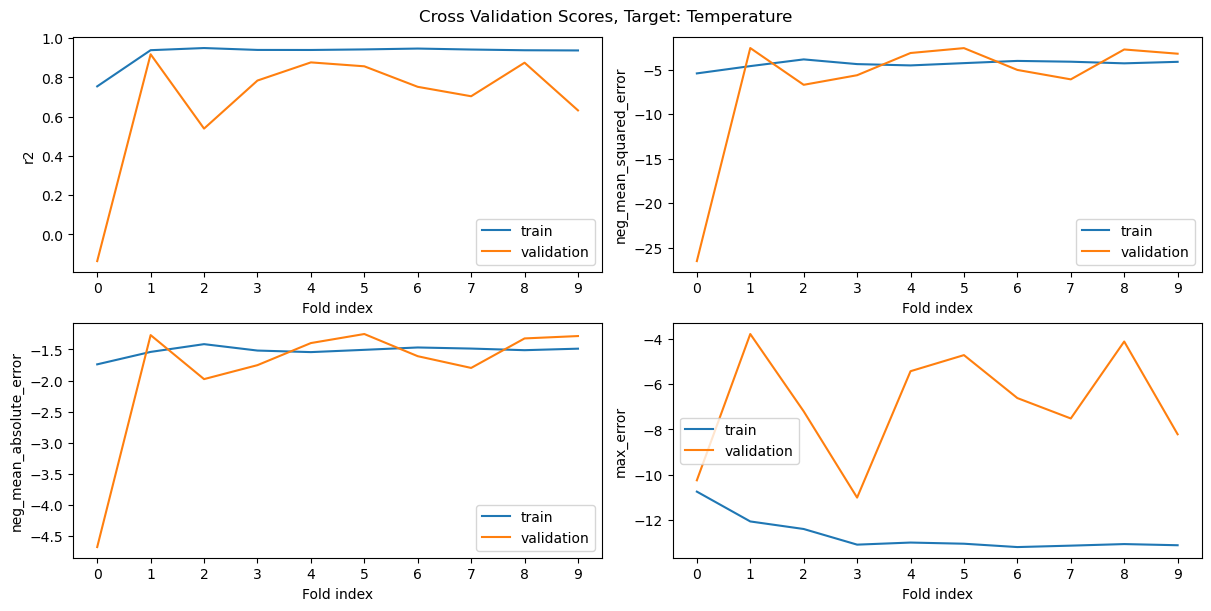

In [85]:
plot_score_cv(cv_results_temperature, target = "Temperature")

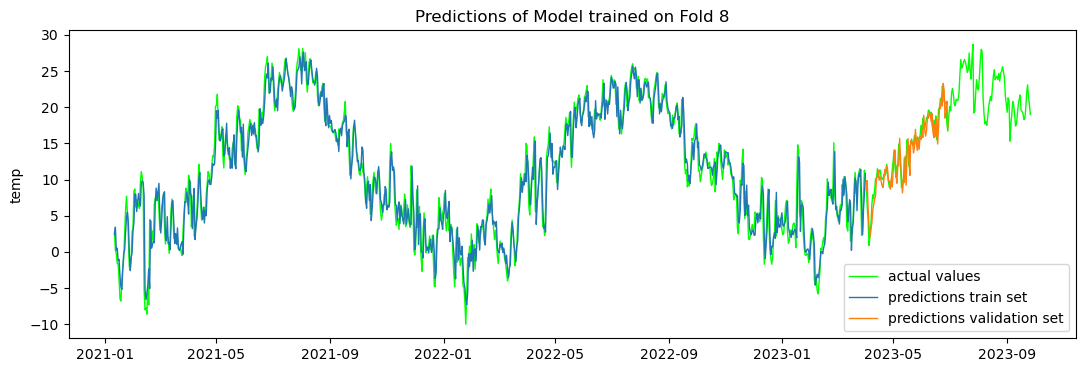

In [86]:
plot_cv_predictions(cv_results_temperature,  weather_data_with_lags, "temp", n_fold = 8)

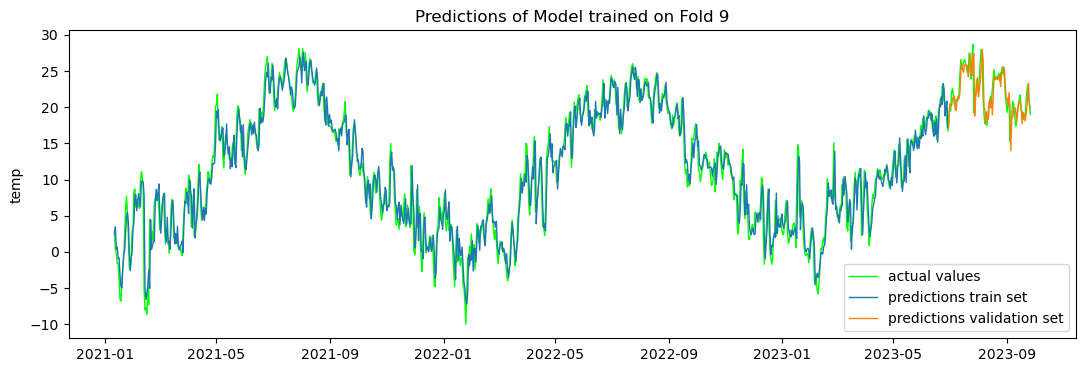

In [87]:
plot_cv_predictions(cv_results_temperature,  weather_data_with_lags, "temp", n_fold = 9)

In [88]:
feature_names = pipe_linear_regression_base_features[-2].get_feature_names_out()

In [94]:
pd.DataFrame([estimator["model"].coef_ for estimator in cv_results_temperature["estimator"]], columns = feature_names).rename_axis("Fold_Index")

,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6,temp_7,temp_8,temp_9,temp_10,...,cloudcover_1,cloudcover_2,cloudcover_3,cloudcover_4,cloudcover_5,cloudcover_6,cloudcover_7,cloudcover_8,cloudcover_9,cloudcover_10
Fold_Index,,,,,,,,,,,,,,,,,,,,,
0,18.587102,-4.079364,3.116180,-5.053692,4.572908,-6.772952,6.963438,-2.621631,2.879279,-3.928251,...,-3.297043,0.482275,-0.363478,-0.771358,-0.407981,-0.246648,0.227022,1.907814,-1.321374,-0.184811
1,34.383501,-4.496522,1.077331,-2.321202,5.397575,-6.593020,8.079659,-1.685892,2.314838,-0.989807,...,-3.770595,0.057783,1.013050,-0.751831,0.633364,0.345054,0.602331,1.240586,0.385845,0.555226
2,35.734363,-6.499184,3.989204,-4.259658,4.962526,-4.846860,7.972143,-3.254225,3.577667,-1.128744,...,-3.623500,0.230650,0.975264,-0.389374,0.556463,-0.285907,0.656724,1.253383,0.532359,0.911169
3,34.770371,-4.879509,2.024399,-1.212540,1.799465,-2.315931,5.751707,-0.175903,-1.017937,1.279529,...,-3.156114,0.210662,0.522994,-0.095843,0.426609,-0.766956,1.205401,0.499232,0.276975,0.969141
4,35.680515,-5.639626,3.871213,-2.556401,1.540901,-0.007852,5.059714,-0.899415,0.123569,-0.096738,...,-3.076891,0.362445,-0.035683,0.128237,0.718344,-1.043295,1.209759,0.880946,-0.293388,0.527091
5,35.300412,-5.202111,3.590585,-2.026220,1.042836,-0.760118,5.986717,-1.103011,0.260657,-0.159201,...,-3.273697,0.339611,0.154610,0.113704,0.502056,-0.812216,1.002062,0.824831,-0.372028,0.387805
6,35.866719,-5.268247,3.344629,-2.236011,0.693152,-0.376170,5.223296,-1.011569,0.382505,0.247753,...,-3.224764,0.436784,0.121221,0.170308,0.618481,-0.944976,0.941228,0.720466,-0.607412,0.612792
7,36.284004,-6.150721,3.186739,-2.320551,1.593780,0.594008,3.266303,-0.398204,-0.358312,1.316950,...,-2.822666,0.319508,-0.048372,0.037861,1.108139,-1.033837,1.020344,0.443910,-0.540403,0.627690
8,36.563035,-6.994844,2.800390,-0.519344,0.480167,1.252764,2.422559,-0.907312,-0.066376,1.516309,...,-2.947430,0.446283,-0.370764,0.192536,1.131875,-1.109498,1.060140,0.240370,-0.496243,0.111589


In [95]:
weather_data_with_lags.precip = weather_data_with_lags.precip.fillna(0)

In [96]:
cv_results_precip = cross_validate(
    pipe_linear_regression_base_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.precip, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

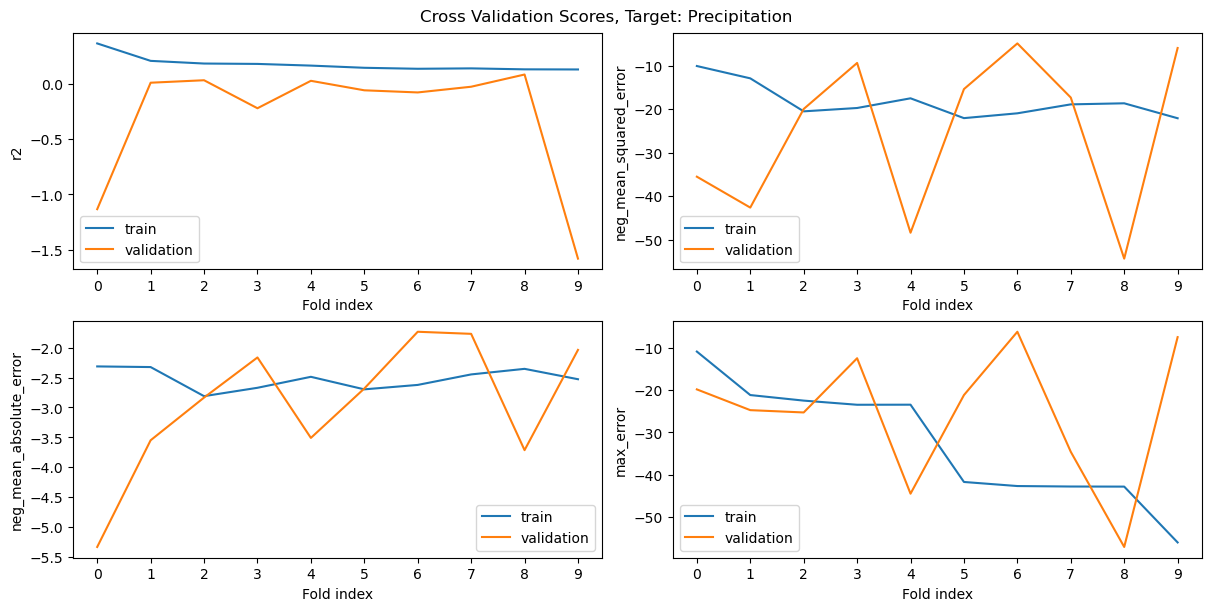

In [97]:
plot_score_cv(cv_results_precip, target = "Precipitation")

Well, disastrous results. R2 is even negative, which means we would be better off predicting the mean value then trying to make a model. These results are no surprise - we know from the EDA that precipitation has exponential distribution and linear regression is unlikely to describe it well, especially since we have applied logarithmic transformation on the input variables (the lags), but not on the target. We keep target precipitation without transformation for now for consistency and easier interpretation of the cv scores, but keep in mind to come back to this problem later.

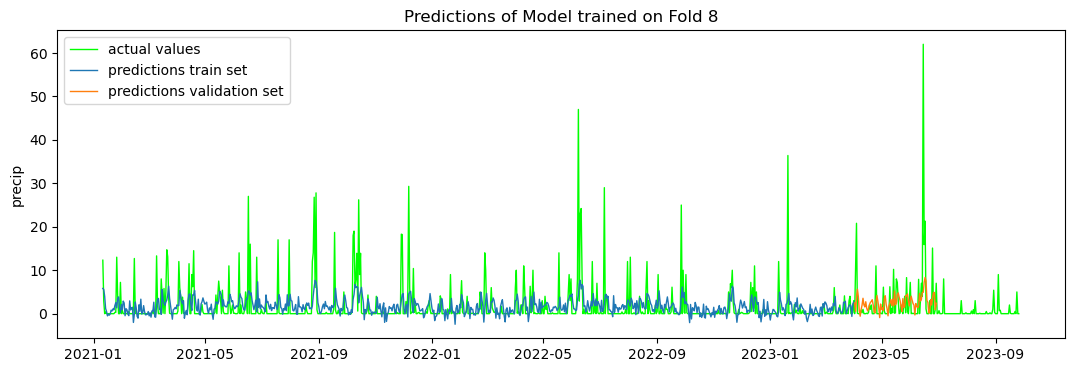

In [98]:
plot_cv_predictions(cv_results_precip,  weather_data_with_lags, "precip", n_fold = 8)

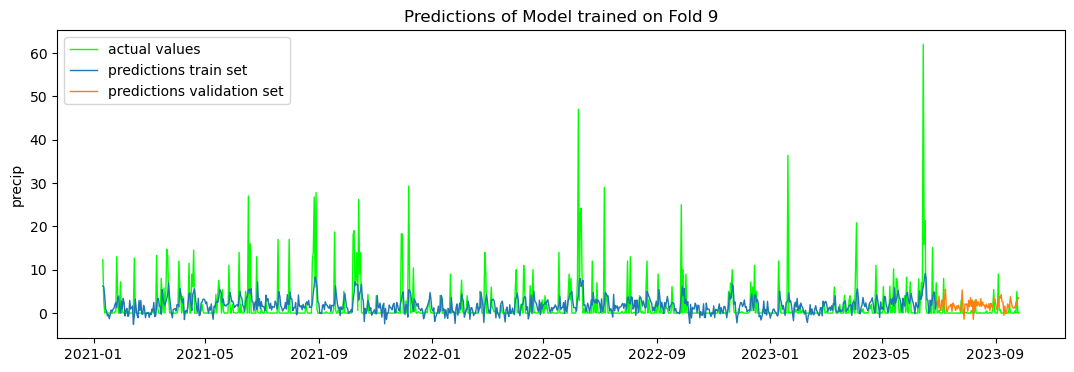

In [99]:
plot_cv_predictions(cv_results_precip,  weather_data_with_lags, "precip", n_fold = 9)

We also need some postprocessor that limits the precipitation to 0 as negative quantities of rain are not possible.

In [100]:
weather_data_with_lags.cloudcover = weather_data_with_lags.cloudcover.fillna(0)

In [101]:
cv_results_cloudcover = cross_validate(
    pipe_linear_regression_base_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.cloudcover, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

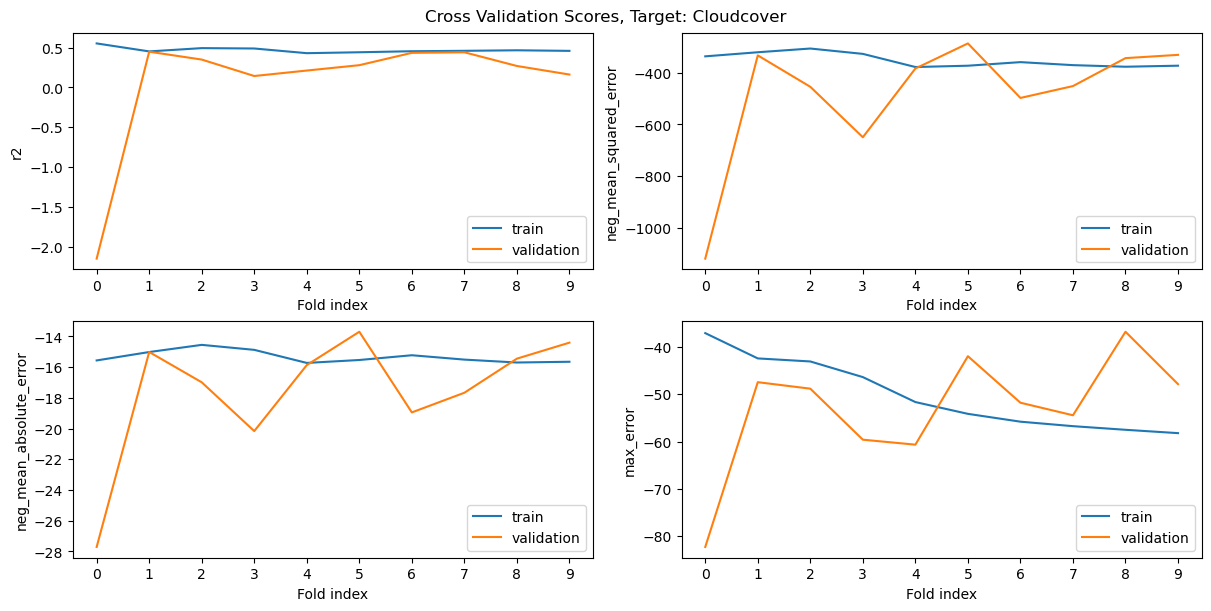

In [102]:
plot_score_cv(cv_results_cloudcover, target = "Cloudcover")

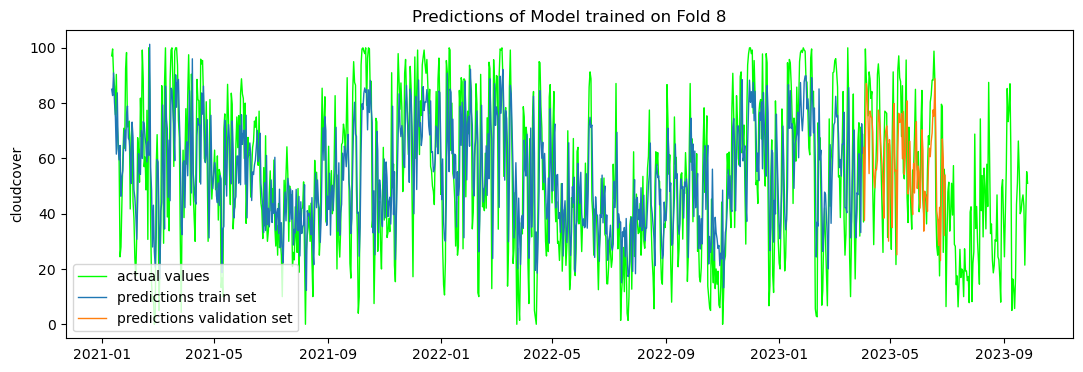

In [103]:
plot_cv_predictions(cv_results_cloudcover,  weather_data_with_lags, "cloudcover", n_fold = 8)

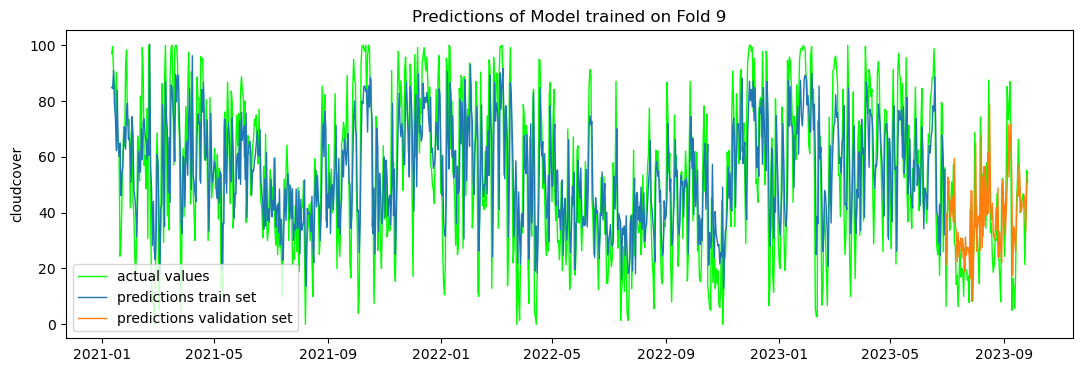

In [104]:
plot_cv_predictions(cv_results_cloudcover,  weather_data_with_lags, "cloudcover", n_fold = 9)

Need more input data -> + columns

## Adding Time-Related Features

In [105]:
weather_data_with_lags["dt_year"] = weather_data_with_lags.datetime.dt.year  # nominal
weather_data_with_lags["dt_month"] = weather_data_with_lags.datetime.dt.month  # nominal
weather_data_with_lags["dt_week_of_year"] = weather_data_with_lags.datetime.dt.isocalendar().week # ordinal
weather_data_with_lags["dt_day_of_year"] = weather_data_with_lags.datetime.dt.day_of_year # ordinal

In [106]:
def sin_name_out(self, input_features):
    return [f"{feature}_sin" for feature in input_features]

def cos_name_out(self, input_features):
    return [f"{feature}_cos" for feature in input_features]

In [107]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi), feature_names_out = sin_name_out)


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi), feature_names_out = cos_name_out)



In [108]:
time_transformer = ColumnTransformer(
        transformers=[
            ("nominal", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["dt_year"]),
            ("week_sin", sin_transformer(52), ["dt_week_of_year"]),
            ("week_cos", cos_transformer(52), ["dt_week_of_year"]),
            ("day_sin", sin_transformer(365), ["dt_day_of_year"]),
            ("day_cos", cos_transformer(365), ["dt_day_of_year"]),
            ],
    verbose_feature_names_out = False
)

Default setting of OneHotEncoder - handle_unknown="error" was changed to handle_unknown="ignore", because some folds have categories in the validation set, that are not present in the training set. For example, years seen during fit are 2021 and 2022, and transforming 2023 is not possible.  

At first we tried handling `dt_month` as nominal category, hoping it will give the model more flexibility, but it led to exploding gradients - coefficients and intercept with order of $e^{14}$. This is less likely to happen in a model with more independent features or one with regularization or dimensionality reduction, so we may try this approach later in this work. In the current experiment `dt_month` is ignored.

In [109]:
time_features = time_transformer.fit_transform(weather_data_with_lags) # just checking, actual fit inside cv

In [110]:
time_transformer.get_feature_names_out()

array(['dt_year_2021', 'dt_year_2022', 'dt_year_2023',
       'dt_week_of_year_sin', 'dt_week_of_year_cos', 'dt_day_of_year_sin',
       'dt_day_of_year_cos'], dtype=object)

In [111]:
len(time_transformer.get_feature_names_out())

7

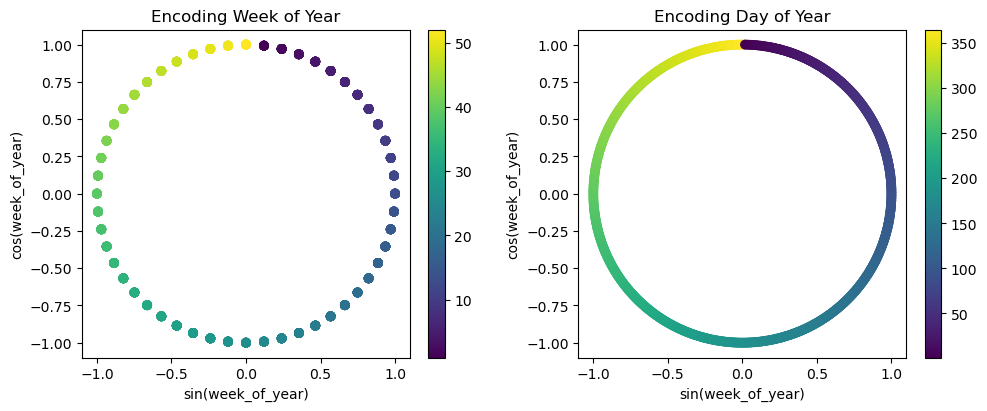

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout = True)

features = ["dt_week_of_year", "dt_day_of_year"]
titles = ["Encoding Week of Year", "Encoding Day of Year"]
sin_column_index = [3, 5]

for i, ax in enumerate(axs):
    scatter = ax.scatter(time_features[:,sin_column_index[i]], time_features[:,sin_column_index[i] + 1], c=weather_data_with_lags[features[i]])
    colorbar = fig.colorbar(scatter)
    
    ax.set_title(titles[i])
    ax.set_aspect("equal")
    ax.set(
        xlabel="sin(week_of_year)",
        ylabel="cos(week_of_year)",
    )

plt.show()

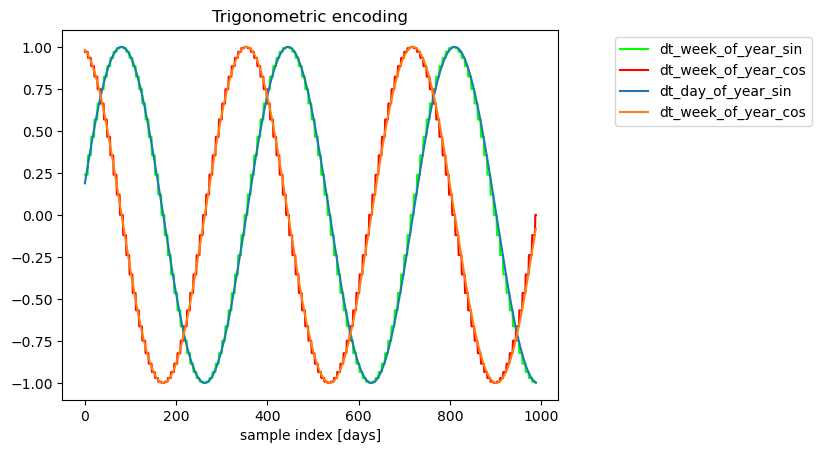

In [113]:
plt.plot(weather_data_with_lags.index, time_features[:,3], c = "lime", label = "dt_week_of_year_sin")
plt.plot(weather_data_with_lags.index, time_features[:,4], c = "red", label = "dt_week_of_year_cos")

plt.plot(weather_data_with_lags.index, time_features[:,5], label = "dt_day_of_year_sin")
plt.plot(weather_data_with_lags.index, time_features[:,6], label = "dt_week_of_year_cos")

plt.xlabel("sample index [days]")
plt.title("Trigonometric encoding")
plt.legend(bbox_to_anchor=(1.1, 1))

plt.show()

In [114]:
pipe_linear_time_features = Pipeline(
    steps=[
        ("time_transform", time_transformer),
        ("model", LinearRegression())
    ]
)

In [115]:
pipe_linear_time_features.fit(weather_data_with_lags, weather_data_with_lags.temp) # just checking

Pipeline(steps=[('time_transform',
                 ColumnTransformer(transformers=[('nominal',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['dt_year']),
                                                 ('week_sin',
                                                  FunctionTransformer(feature_names_out=<function sin_name_out at 0x0000017D513180E0>,
                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x0000017D51923920>),
                                                  ['dt_week_of_year']),
                                                 ('week_cos',
                                                  Funct...
                                                  FunctionTransformer(feature_names_out=<function sin_name_out at 0x0000017D513180E0>,
                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x0000017D51923EC0>),
                                                  ['dt_day_of_year']),
                                                 ('day_cos',
                                                  FunctionTransformer(feature_names_out=<function cos_name_out at 0x0000017D53325D00>,
                                                                      func=<function cos_transformer.<locals>.<lambda> at 0x0000017D51938680>),
                                                  ['dt_day_of_year'])],
                                   verbose_feature_names_out=False)),
                ('model', LinearRegression())])

In [116]:
# pipe_linear_time_features["model"].coef_

In [117]:
# pipe_linear_time_features["model"].intercept_

In [118]:
pipe_linear_time_features["model"].n_features_in_

7

In [119]:
cv_results_temperature = cross_validate(
    pipe_linear_time_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.temp, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

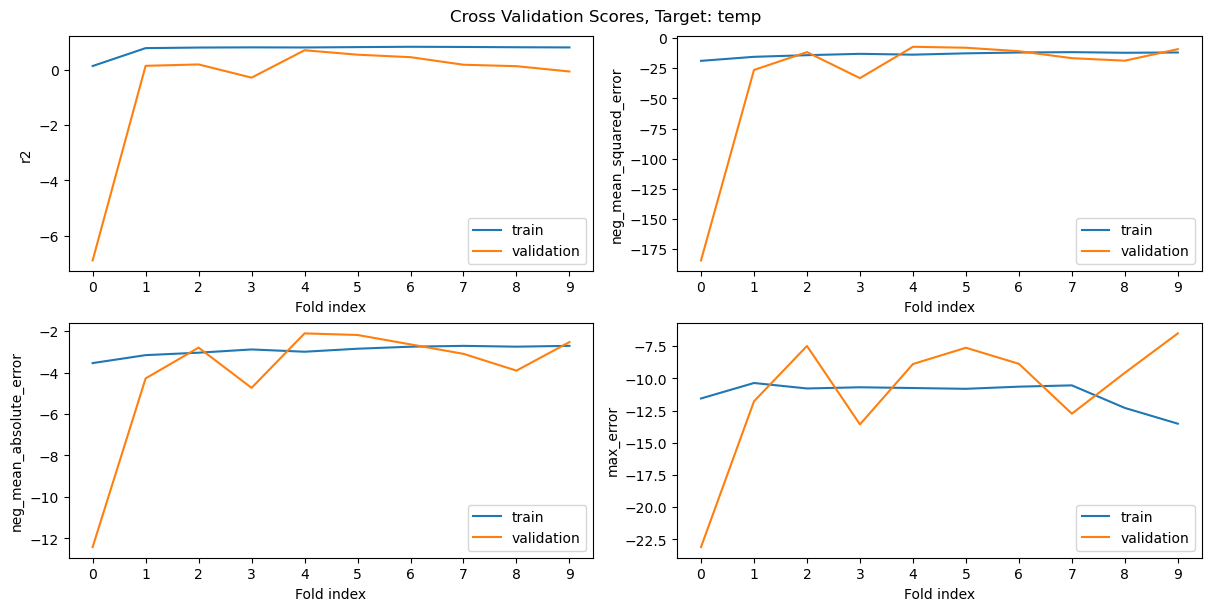

In [120]:
plot_score_cv(cv_results_temperature)

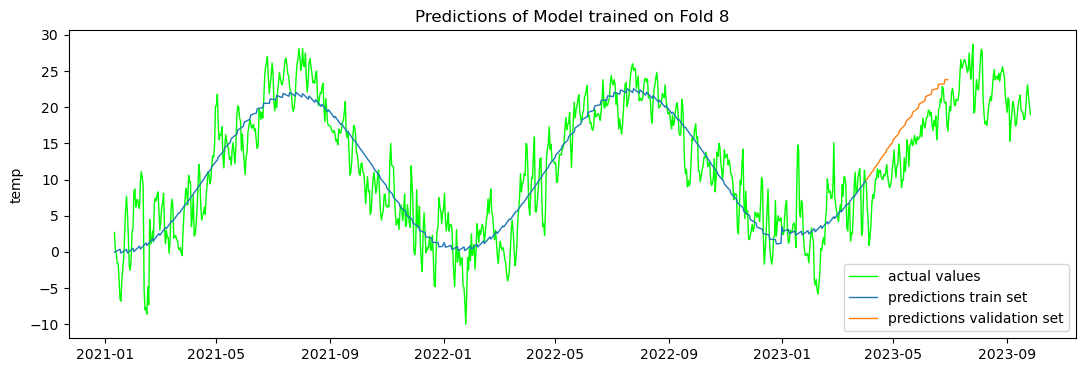

In [121]:
plot_cv_predictions(cv_results_temperature, weather_data_with_lags, "temp", n_fold = 8)

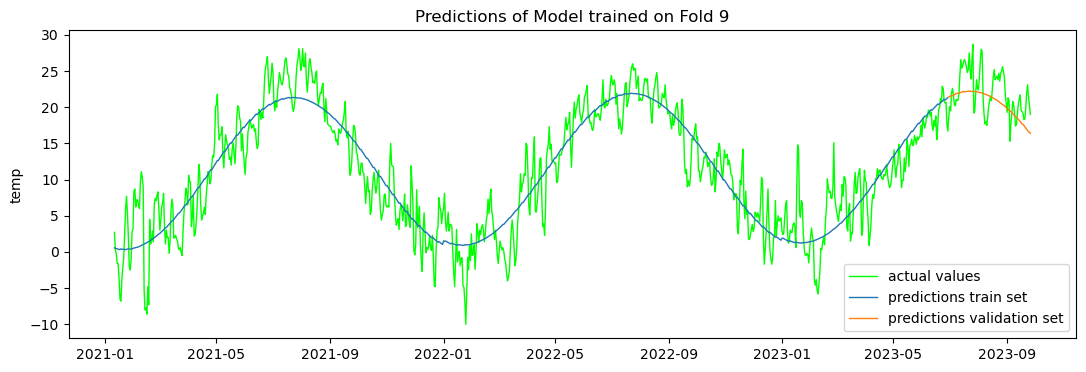

In [122]:
plot_cv_predictions(cv_results_temperature, weather_data_with_lags, "temp", n_fold = 9)

In [123]:
feature_names = pipe_linear_time_features[-2].get_feature_names_out()

In [124]:
pd.DataFrame([cv_results_temperature["estimator"][i]["model"].coef_ for i in range(10)], columns = feature_names)

,dt_year_2021,dt_year_2022,dt_year_2023,dt_week_of_year_sin,dt_week_of_year_cos,dt_day_of_year_sin,dt_day_of_year_cos
0,0.000000e+00,6.610097e+00,-3.120227e+00,-3.310956,0.561005,NaN,NaN
1,0.000000e+00,1.611909e-01,-2.533670e+00,-6.627260,-6.825594,NaN,NaN
2,0.000000e+00,-7.324886e+00,-4.148015e-02,3.600569,-10.436051,NaN,NaN
3,-2.001369e+00,2.001369e+00,-9.671050e+00,-2.730470,6.094136,-7.693357,NaN
4,-1.093317e-01,1.093317e-01,-9.789625e+00,-2.207749,6.127876,-8.199424,NaN
5,-1.020488e-01,1.020488e-01,-6.400008e+00,2.972057,2.768491,-13.424842,NaN
6,-6.215732e-03,6.215732e-03,-4.566638e+00,-1.101230,1.012473,-9.401619,NaN
7,-8.750004e-01,-4.596172e-01,1.334618e+00,-5.300076,-0.774982,1.527036,-9.392335
8,-1.027065e+00,-6.119749e-01,1.639040e+00,-5.192608,0.703634,1.418810,-10.856127
9,-8.092210e+13,-8.092210e+13,-8.092210e+13,1.386528,1.431960,-5.142478,-11.237339


Skip year, keep cyclic day

In [125]:
cv_results_precip = cross_validate(
    pipe_linear_time_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.precip, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

In [126]:
# plot_score_cv(cv_results_precip)

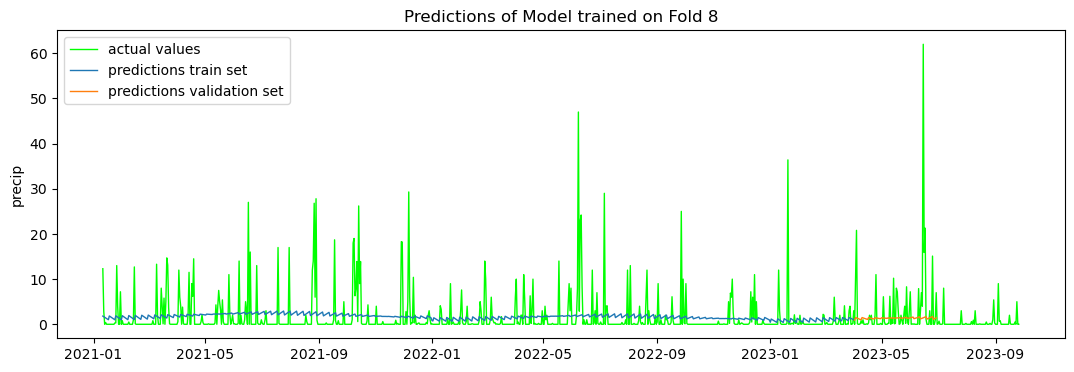

In [127]:
plot_cv_predictions(cv_results_precip, weather_data_with_lags, "precip", n_fold = 8)

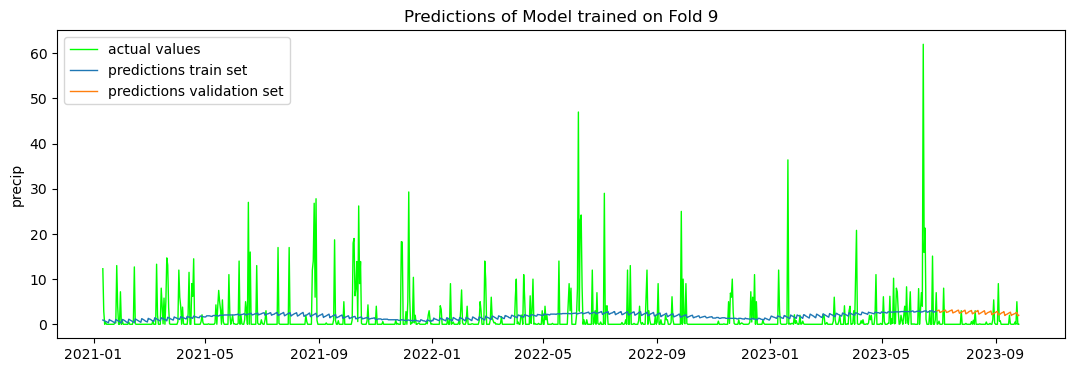

In [128]:
plot_cv_predictions(cv_results_precip, weather_data_with_lags, "precip", n_fold = 9)

In [129]:
pd.DataFrame([cv_results_precip["estimator"][i]["model"].coef_ for i in range(10)], columns = feature_names)

,dt_year_2021,dt_year_2022,dt_year_2023,dt_week_of_year_sin,dt_week_of_year_cos,dt_day_of_year_sin,dt_day_of_year_cos
0,0.000000e+00,8.572553e+00,-1.671717e+00,-13.825537,-3.566826,NaN,NaN
1,0.000000e+00,3.600162e+00,-4.619526e+00,-2.720170,4.219326,NaN,NaN
2,0.000000e+00,6.040403e+00,-1.516025e+01,-6.797717,15.372210,NaN,NaN
3,6.832876e-01,-6.832876e-01,1.566415e+01,-11.225112,-16.062774,10.987832,NaN
4,3.601386e-01,-3.601386e-01,1.348301e+01,-4.234752,-13.771586,3.939888,NaN
5,-7.998045e-02,7.998045e-02,7.587150e+00,-4.063315,-8.086397,3.382207,NaN
6,1.288735e-01,-1.288735e-01,1.019613e+01,-6.698274,-10.479263,6.142202,NaN
7,7.152166e-01,2.455798e-01,-9.607965e-01,7.783875,-8.018421,-7.932560,7.400783
8,4.463447e-01,-2.493505e-02,-4.214097e-01,6.504360,-6.069920,-6.658203,5.502714
9,-4.371941e+14,-4.371941e+14,-4.371941e+14,4.810083,-6.235458,-5.012531,5.401272


In [130]:
cv_results_cloudcover = cross_validate(
    pipe_linear_time_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.cloudcover, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

In [131]:
# plot_score_cv(cv_results_cloudcover)

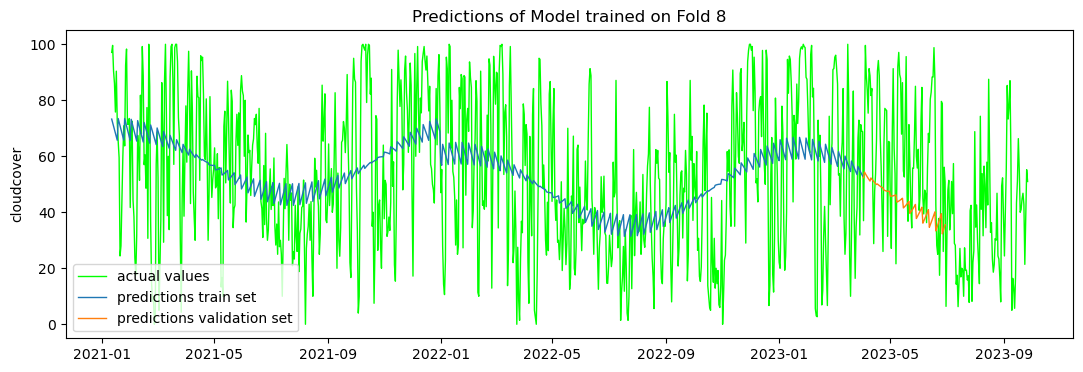

In [132]:
plot_cv_predictions(cv_results_cloudcover, weather_data_with_lags, "cloudcover", n_fold = 8)

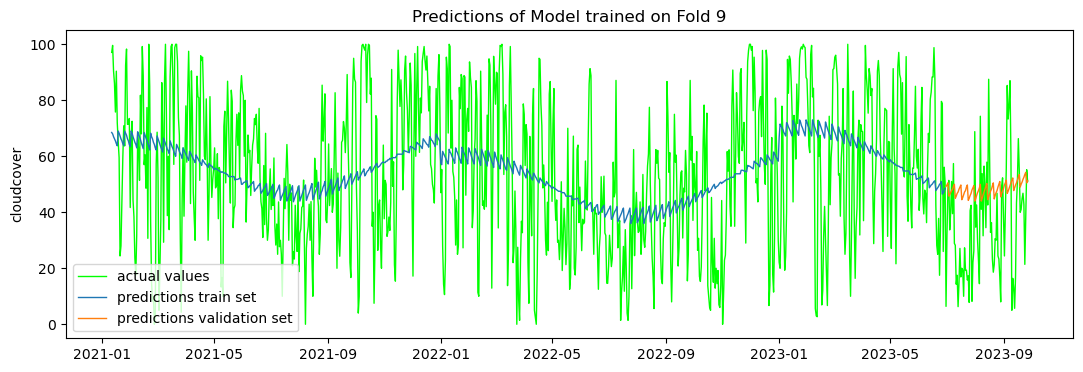

In [133]:
plot_cv_predictions(cv_results_cloudcover, weather_data_with_lags, "cloudcover", n_fold = 9)

In [134]:
pd.DataFrame([cv_results_cloudcover["estimator"][i]["model"].coef_ for i in range(10)], columns = feature_names)

,dt_year_2021,dt_year_2022,dt_year_2023,dt_week_of_year_sin,dt_week_of_year_cos,dt_day_of_year_sin,dt_day_of_year_cos
0,0.000000e+00,-3.097940e+01,-1.037263e+02,-33.539937,61.001396,NaN,NaN
1,0.000000e+00,3.127643e+01,-8.373042e+01,-19.477964,86.670143,NaN,NaN
2,0.000000e+00,3.377071e+01,-7.007851e+01,-30.959153,78.361181,NaN,NaN
3,6.095979e+00,-6.095979e+00,7.204022e+01,-59.433088,-68.848799,69.036615,NaN
4,4.472994e+00,-4.472994e+00,6.360623e+01,-35.064666,-60.171749,45.154888,NaN
5,4.648772e+00,-4.648772e+00,7.355142e+01,-37.443412,-70.160693,47.501294,NaN
6,4.333971e+00,-4.333971e+00,8.115999e+01,-24.886787,-78.261676,35.196198,NaN
7,2.004141e+01,1.026319e+01,-3.030460e+01,74.170000,-35.583488,-70.356437,45.908352
8,6.360773e+00,-3.425401e+00,-2.935371e+00,70.211034,-26.091362,-66.388555,36.680127
9,-1.153994e+15,-1.153994e+15,-1.153994e+15,43.086870,-35.396879,-39.251534,44.086984


### Linear Model All Features

In [140]:
#weather_data.columns

In [151]:
#weather_data_with_lags.columns

In [147]:
# features_with_lag

In [152]:
n_lags

10

In [223]:
numeric_normal = [
    "tempmax",
     "tempmin",
     "temp",
     "dew",
     "humidity",
     "windgust",
     "windspeed",
     "sealevelpressure",
     "cloudcover"    
]
numeric_log_features = [
    "precip"
]
numeric_cyclic_features = [
    "winddir"
]
categorical_features = [
    "preciptype",
    "conditions"
]
text_features = [
    "description"
]

In [224]:
# make_column_selector(pattern = "sno|temp")(weather_data_with_lags)

In [225]:
def lag_column_selector(lag_features): # ugly but it's working
   return  make_column_selector(pattern = "|".join([f"{feature}_" for feature in lag_features]))

In [226]:
# lag_column_selector(numeric_normal)(weather_data_with_lags)

In [227]:
preprozess_time_features = ColumnTransformer(
            transformers=[
                ("month_categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["dt_month"]),
                ("day_sin", sin_transformer(365), ["dt_day_of_year"]),
                ("day_cos", cos_transformer(365), ["dt_day_of_year"]),
            ],
    verbose_feature_names_out = False
)

In [228]:
preprozess_numeric_normal = Pipeline(
            steps=[
                ("impute", SimpleImputer(strategy = "constant", fill_value = 0)),
                ("scale", MinMaxScaler())
            ]
)

In [229]:
preprozess_numeric_log = Pipeline(
            steps=[
                ("impute", SimpleImputer(strategy = "constant", fill_value = 0)),
                ("log_transform", FunctionTransformer(np.log1p, feature_names_out = "one-to-one"))
            ]
)

In [230]:
preprozess_numeric_cyclic = ColumnTransformer(  # TODO: remove hardcode
            transformers=[
                ("winddir_sin", sin_transformer(360), make_column_selector(pattern = "winddir")),
                ("winddir_cos", cos_transformer(360), make_column_selector(pattern = "winddir")),
            ],
    verbose_feature_names_out = False
)

In [231]:
# preprozess_numeric_cyclic.fit_transform(weather_data_with_lags)

In [232]:
# preprozess_numeric_cyclic.get_feature_names_out()

Preprocess multi categorical features:

In [233]:
token_pattern = r"(?u)\b[^,]+\b" # honorable mention to ChatGPT for outstanding knowledge in the field of RegEx patterns
# pattern means we keep words separated by space in single token (like "partialy cloudy") and split only by comma

In [234]:
count_vec_test = CountVectorizer(token_pattern = token_pattern)

In [235]:
count_vec_test.fit_transform([
    "first, words with space,noSpaceAfterComma, word, word, lastWord", 
    "firstWord, words with space,noSpaceAfterComma, UPPerCase, lastWord"]).toarray()

array([[1, 0, 1, 1, 0, 2, 1],
       [0, 1, 1, 1, 1, 0, 1]], dtype=int64)

In [236]:
count_vec_test.vocabulary_

{'first': 0,
 'words with space': 6,
 'nospaceaftercomma': 3,
 'word': 5,
 'lastword': 2,
 'firstword': 1,
 'uppercase': 4}

In [237]:
multi_column_vectorizer = ColumnTransformer(
            transformers=[
                (x, CountVectorizer(token_pattern = token_pattern), x) for x in lag_column_selector(categorical_features)(weather_data_with_lags)
            ],
    verbose_feature_names_out = True
)

In [238]:
multi_column_vectorizer.fit_transform(weather_data_with_lags).shape

(989, 80)

In [239]:
len(multi_column_vectorizer.get_feature_names_out())

80

In [240]:
# "multi_column_vectorizer" needs to be first step in pipeline to work - input pd with column names not np
# Coludn't make it work with all columns / array - spent too much time in that rabbit hole
# Maybe should have made custom transformer instead of using CountVectorizr, but it's too late now

# preprozess_categorical = Pipeline(
#             steps=[
#                 ("impute", SimpleImputer(strategy = "constant", fill_value = "None")),
#                 ("multi_column_vectorizer", multi_column_vectorizer),
#             ]
# )

In [241]:
# Maybe add gazillion more columns with tfidf on description

# ColumnTransformer([(x, TfidfVectorizer(), x) for x in textual_columns])

In [244]:
preprozess_all_features = ColumnTransformer(
            transformers=[
                ("time_features", preprozess_time_features, make_column_selector(pattern = "dt_")),
                ("numeric_normal", preprozess_numeric_normal, lag_column_selector(numeric_normal)),
                ("numeric_log", preprozess_numeric_log, lag_column_selector(numeric_log_features)),
                ("numeric_cyclic", preprozess_numeric_cyclic, lag_column_selector(numeric_cyclic_features)),
                ("categorical", multi_column_vectorizer, lag_column_selector(categorical_features))
            ],
    verbose_feature_names_out = False
)

In [245]:
preprozess_all_features.fit(weather_data_with_lags)

ColumnTransformer(transformers=[('time_features',
                                 ColumnTransformer(transformers=[('month_categorical',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                sparse_output=False),
                                                                  ['dt_month']),
                                                                 ('day_sin',
                                                                  FunctionTransformer(feature_names_out=<function sin_name_out at 0x0000017D513180E0>,
                                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x0000017D512B7600>),
                                                                  ['dt_day_of_y...
                                                                  CountVectorizer(token_pattern='(?u)\\b[^,]+\\b'),
                                                                  'conditions_9'),
                                                                 ('preciptype_10',
                                                                  CountVectorizer(token_pattern='(?u)\\b[^,]+\\b'),
                                                                  'preciptype_10'),
                                                                 ('conditions_10',
                                                                  CountVectorizer(token_pattern='(?u)\\b[^,]+\\b'),
                                                                  'conditions_10')]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000017D58188F90>)],
                  verbose_feature_names_out=False)

In [246]:
preprozess_all_features.transform(weather_data_with_lags).shape

(989, 214)

In [247]:
pipe_linear_all_features = Pipeline(
    steps=[
        ("preprocess", preprozess_all_features),
        ("model", LinearRegression())
    ]
)

In [ ]:
# [feat for feat in pipe_linear_all_features[-2].get_feature_names_out() if ("_lag_2" in feat or "dt_" in feat)]

In [248]:
def run_cv_experiment(
        estimator, 
        X, 
        y, 
        cv, # instance of TimeSiresSplit or KFold
        scoring_metrics = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error"), 
        log_experiment = False, 
        experiment_name = "", 
        target_name = ""
        ):

    assert isinstance(cv, TimeSeriesSplit), "cv must be an instance of TimeSeriesSplit"
    
    cv_results = cross_validate(
        estimator, # Estimator
        X, # X
        y, # y
        scoring = scoring_metrics, 
        cv = cv, 
        return_train_score = True, 
        return_indices = True,
        return_estimator = True
        )

    if log_experiment is False:
        return cv_results

    feature_names = None
    feature_count = 0
    try:
        feature_names = estimator[-2].get_feature_names_out()
        feature_count = len(feature_names)
        feature_names = [feat for feat in estimator[-2].get_feature_names_out() if ("_lag_2" in feat or "dt_" in feat)]
    except(AttributeError):
        feature_names = "Estimator does not provide get_feature_names_out"
    
    experiment = mlflow.create_experiment(name = f"{experiment_name}_{feature_count}_features_{target_name}")
    
    n_folds = cv.n_splits
    
    for run_idx in range(n_folds):
        with mlflow.start_run(experiment_id = experiment, run_name=f"fold_{run_idx}"):
            
            mlflow.log_param("cv_n_folds", n_folds)
            mlflow.log_param("cv_type", cv.__class__.__name__)
            mlflow.log_param("target", target_name)
            mlflow.log_param("n_samples_train", len(cv_results["indices"]["train"][run_idx]))
            mlflow.log_param("n_samples_test", len(cv_results["indices"]["test"][run_idx]))
            mlflow.log_param("feature_names", feature_names)
            mlflow.log_param("feature_count", feature_count)
            
    
            for metric in scoring_metrics:
                test_metric_key = f"test_{metric}"
                train_metric_key = f"train_{metric}"
                mlflow.log_metric(test_metric_key, cv_results[test_metric_key][run_idx])
                mlflow.log_metric(train_metric_key, cv_results[train_metric_key][run_idx])

    return cv_results


In [253]:
cv_results_temp = run_cv_experiment(
    pipe_linear_all_features, 
    weather_data_with_lags, 
    weather_data_with_lags.temp,
    time_series_cv, 
    experiment_name = "linear_all", 
    target_name = "temp",
    
    log_experiment = False # False for rerunning the notebook
)

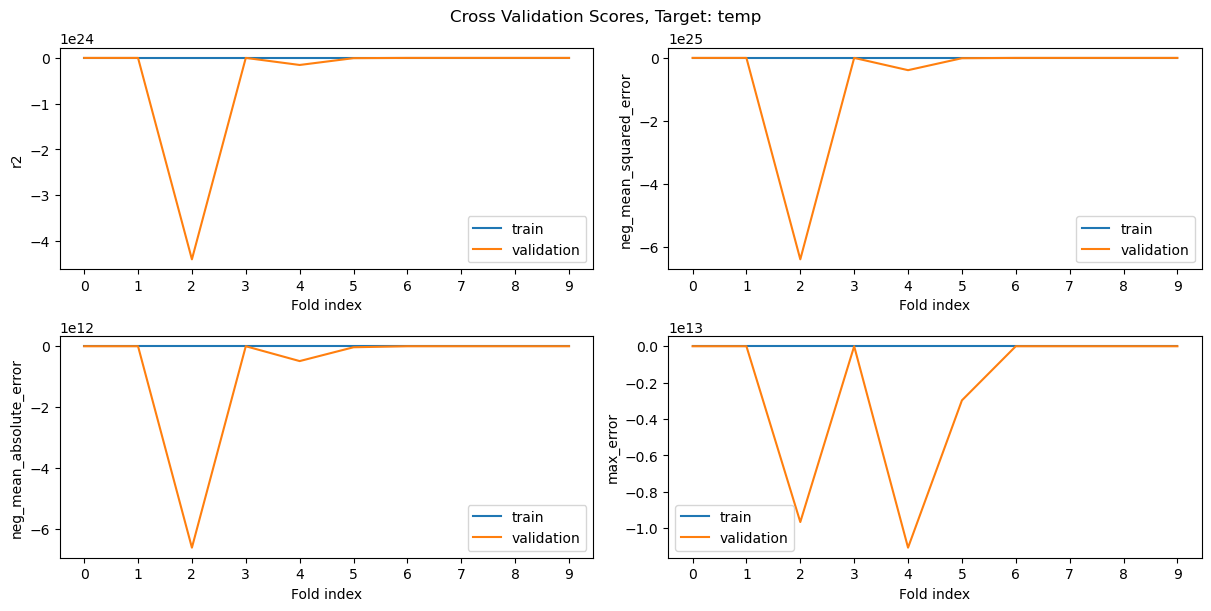

In [262]:
plot_score_cv(cv_results_temp)

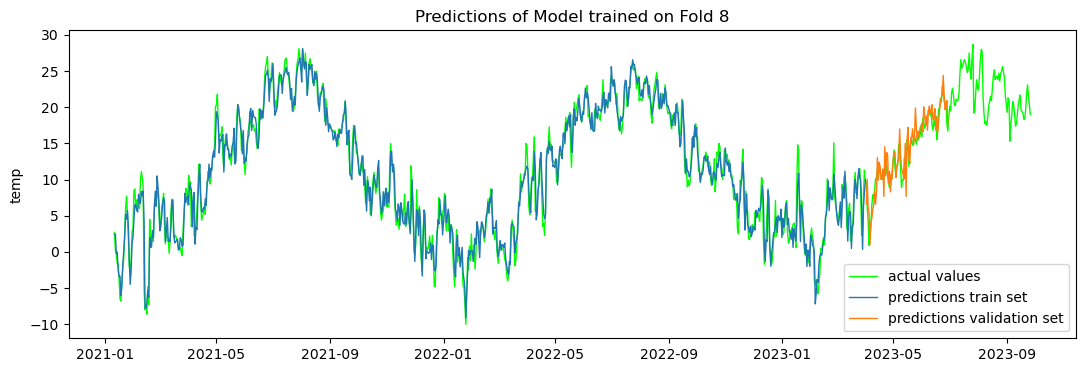

In [263]:
plot_cv_predictions(cv_results_temp, weather_data_with_lags, "temp", n_fold = 8)

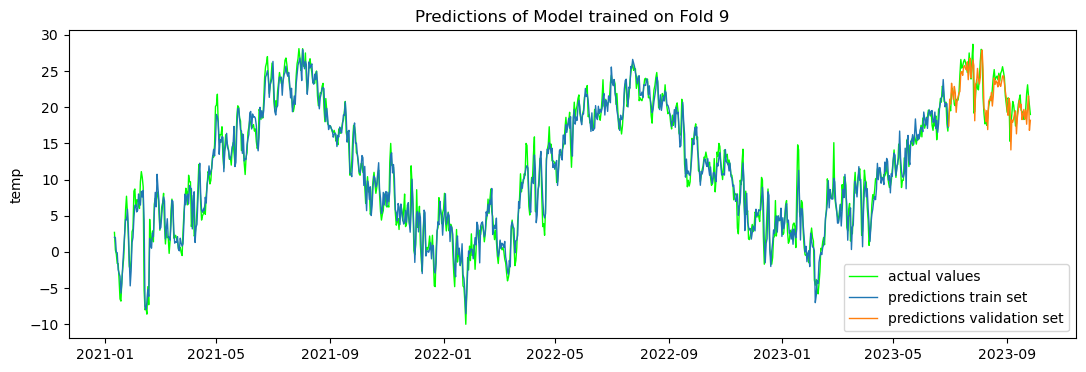

In [264]:
plot_cv_predictions(cv_results_temp, weather_data_with_lags, "temp", n_fold = 9)

In [259]:
cv_results_precip = run_cv_experiment(
    pipe_linear_all_features, 
    weather_data_with_lags, 
    weather_data_with_lags.precip,
    time_series_cv, 
    experiment_name = "linear", 
    target_name = "precip") 

In [ ]:
plot_score_cv(cv_results_precip, skip_folds = 2)

In [ ]:
plot_cv_predictions(cv_results_precip, weather_data_with_lags, "precip", n_fold = 9)

In [ ]:
cv_results_cloudcover = run_cv_experiment(
    pipe_linear_all_features, 
    weather_data_with_lags, 
    weather_data_with_lags.cloudcover,
    time_series_cv, 
    experiment_name = "linear", 
    target_name = "cloudcover") 

In [ ]:
plot_score_cv(cv_results_cloudcover, skip_folds = 2)

In [ ]:
plot_cv_predictions(cv_results_cloudcover, weather_data_with_lags, "cloudcover", n_fold = 9)

In [ ]:
pipe_poly = Pipeline(
    steps=[
        ("preprocess", preprozess_all_features),
        ("polynomials", PolynomialFeatures(degree = 2)),
        ("model", LinearRegression())
    ]
)

In [ ]:
res = pipe_poly.fit(weather_data_with_lags)

In [ ]:
cv_results_cloudcover = run_cv_experiment(
    pipe_poly, 
    weather_data_with_lags, 
    weather_data_with_lags.cloudcover,
    time_series_cv, 
    experiment_name = "poly_3", 
    target_name = "cloudcover")

In [ ]:
plot_cv_predictions(cv_results_cloudcover, weather_data_with_lags, "cloudcover", n_fold = 9)

In [ ]:
token_pattern = r"(?u)\b[^,]+\b" # honorable mention to ChatGPT for outstanding knowledge in the field of RegEx patterns

In [ ]:
count_vectorizer = CountVectorizer(token_pattern = token_pattern)
count_vectorizer.fit(weather_data.conditions.fillna("None"))

In [ ]:
count_vectorizer.get_feature_names_out()

In [ ]:
count_vectorizer.transform(weather_data.conditions).toarray()

In [ ]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value = 0)),
        ("scaler", MinMaxScaler())
    ]
)


# categorical_transformer = Pipeline(
#     steps=[
#         ("multi_hot_encode", CountVectorizer(token_pattern = tocken_pattern))
        

#     ]
# )

column_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("conditions", CountVectorizer(token_pattern = tocken_pattern), "conditions"),
    ],
    verbose_feature_names_out = False,
    sparse_threshold=0.0
)

In [ ]:
weather_features_train_pipe = column_preprocessor.fit_transform(weather_features_train)

In [ ]:
weather_features_train_pipe.shape

In [ ]:
column_preprocessor.get_feature_names_out()

In [ ]:
column_preprocessor.transform(weather_features_train[0:1]).shape

In [ ]:
mlflow.log_param("train_test_split", "default")
mlflow.log_param("train_test_split_random_state", 42)
mlflow.log_param("location", "Sofia")
mlflow.log_param("n_samples", 1000)
# mlflow.log_param("alpha", 1)
# mlflow.log_param("solver", "auto")

In [ ]:
ridge_pipeline = Pipeline([
    ("feature preprocess", column_preprocessor),
    ("ridge", Ridge())
])

In [ ]:
param_grid = {"ridge__alpha": [0.01, 0.1, 1, 10, 20, 100, 1000]}

In [ ]:
grid_search = GridSearchCV(
    ridge_pipeline, param_grid = param_grid,
    cv = 10
)

In [ ]:
mlflow.log_params(param_grid)
mlflow.log_param("cv", 10)

In [ ]:
grid_search.fit(weather_features_train, next_temp_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.cv_results_

In [ ]:
r2_train = grid_search.best_score_
r2_train

In [ ]:
best_ridge = grid_search.best_estimator_

In [ ]:
r2_val = best_ridge.score(weather_features_val, next_temp_val)
r2_val

In [ ]:
ridge_pipeline[-2].get_feature_names_out()

In [ ]:
best_ridge["ridge"].coef_

In [ ]:
best_ridge["ridge"].get_params()

In [ ]:
r2_train = best_ridge["ridge"].score(weather_features_train_pipe, next_temp_train)
r2_train

In [ ]:
weather_features_val_pipe = column_preprocessor.transform(weather_features_val)

In [ ]:
r2_val = best_ridge["ridge"].score(weather_features_val_pipe, next_temp_val)
r2_val

In [ ]:
# hurrray

In [ ]:
mlflow.log_metric("r2_train", r2_train)

In [ ]:
mlflow.log_metric("r2_val", r2_val)

In [ ]:
mlflow.end_run()

In [ ]:
data_after_pipe = preprocessor.transform(mussala_weather_data)
data_after_pipe

In [ ]:
pca = PCA()

In [ ]:
pca.fit(data_after_pipe)

In [ ]:
plt.bar(range(data_after_pipe.shape[1]), pca.explained_variance_ratio_)
plt.show()